Kept for reference
- orients: (J, Quaternion). Quaternion is class defined under common/Quaternions.py.
- offsets: (J, 3)
- positions: (F, J, 3)
- rotZtions: (F, J, Quaternion)

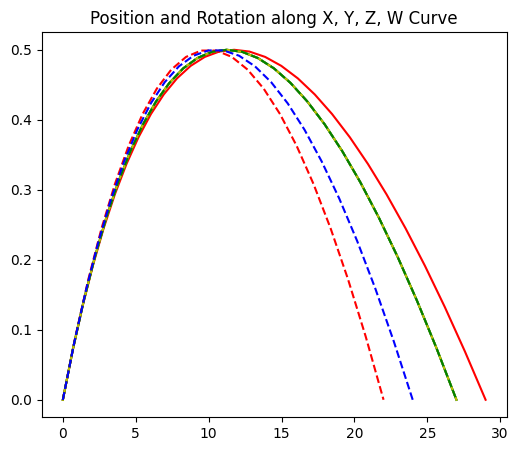

In [10]:
import os
import argparse
import numpy as np
import bezier
import matplotlib.pyplot as plt
import sys
import config

sys.path.append('common')
from BVH import load, save
from MovementCurve import MovementCurve
from Quaternions import Quaternions

config.curve_index = -1
src_path = 'data/Walking_01.bvh'
dst_path = 'output/'
os.makedirs(dst_path, exist_ok=True)

anim, joint_names, frame_time, order = load(src_path)                             # Load data from bvh file

# print(joint_names[:])
def joint_index(joint_name):
    if isinstance(joint_name, list):
        return [joint_names.index(j) for j in joint_name]
    return joint_names.index(joint_name)
def joint_name_from_index(joint_index):
    if isinstance(joint_index, list):
        return [joint_names[i] for i in joint_index]
    return joint_names[joint_index]
def graph_from_joints(joints_info, ax = None):
    if ax is None:
        ax = plt.gca()
    joint_indices = [(joint_name_from_index(joint_info.joint_index)) for joint_info in joints_info]
    joint_indices = list(dict.fromkeys(joint_indices))
    title_new = ax.get_title()
    title_with_line_breaks = ""
    i = 0
    for j in joint_indices:
        i += 1
        title_with_line_breaks += j + ", "
        if(i % 4 == 0):
            title_with_line_breaks += "\n"
    title_new = title_new.replace("Curve", "Curve for " + title_with_line_breaks)
    ax.set_title(title_new)
    

# Set the walk cycles in place
anim.positions[:,0,2] = 0


# Get total length of animation
frame_length = anim.positions.shape[0]

lowest_point = 0
lowest_point_frame = -1
for i in range(frame_length):
    root_y_pos = anim.positions[i,0,1]
    if(root_y_pos > lowest_point):
        lowest_point = root_y_pos
        lowest_point_frame = i

if(lowest_point_frame == -1):
    print("Error: No lowest point found, defaulting to 0")
    lowest_point_frame = 0


class JointInfo:
    def __init__(self, joint_name, apply_strength, MovementCurve = None, move_frequency = 1):
        if MovementCurve is None:
            print("Warning: MovementCurve is None, defaulting to empty list")
            MovementCurve = []
        if not isinstance(MovementCurve, list):
            MovementCurve = [MovementCurve]
        self.MovementCurve = MovementCurve
        self.joint_index = joint_index(joint_name)
        self.apply_strength = apply_strength
        self.move_frequency = move_frequency
    def __str__(self):
        return "Joint name: " + str(self.joint_name) + " Apply strength: " + str(self.apply_strength) + " Move frequency: " + str(self.move_frequency)

rotZ = MovementCurve(MovementCurve.Curve_Type.ROTATION, MovementCurve.Axis.Z, frame_length, lowest_point_frame)
rotX = MovementCurve(MovementCurve.Curve_Type.ROTATION, MovementCurve.Axis.X, frame_length + 2, lowest_point_frame, ax=rotZ.ax)
rotY = MovementCurve(MovementCurve.Curve_Type.ROTATION, MovementCurve.Axis.Y, frame_length, lowest_point_frame, ax=rotZ.ax)
rotW = MovementCurve(MovementCurve.Curve_Type.ROTATION, MovementCurve.Axis.W, frame_length, lowest_point_frame, ax=rotZ.ax)
posX = MovementCurve(MovementCurve.Curve_Type.POSITION, MovementCurve.Axis.X, frame_length - 5, lowest_point_frame, ax=rotZ.ax)
posY = MovementCurve(MovementCurve.Curve_Type.POSITION, MovementCurve.Axis.Y, frame_length, lowest_point_frame, ax=rotZ.ax)
posZ = MovementCurve(MovementCurve.Curve_Type.POSITION, MovementCurve.Axis.Z, frame_length - 3, lowest_point_frame, ax=rotZ.ax)

rotA = [rotZ, rotX, rotY, rotW]
posA = [posX, posY, posZ]


joints_to_move = [JointInfo("Hips",1,rotY),JointInfo("Hips",-.1,posY),JointInfo("Hips",-.1,rotX),JointInfo("Spine",-1,rotX),
    JointInfo("Spine1",-0.2,rotX),JointInfo("Head",1,[rotY,rotX]),JointInfo("Head",0.3,[posY,rotZ]),
    JointInfo("Head",-.3,rotX),JointInfo("LeftShoulder",1,rotY),JointInfo("LeftArm",1,rotY),
    JointInfo("LeftForeArm",1,rotY),JointInfo("LeftHand",1,rotY),JointInfo("RightShoulder",1,rotY),
    JointInfo("LeftUpLeg",-1,rotY),JointInfo("LeftLeg",-1,rotY),JointInfo("Spine2",-.1,posY)]

# graph_from_joints(joints_to_move)

for i in range(frame_length):
    for j in joints_to_move:
        # For each movement curve, add the value to the existing rotation or position
        for m in j.MovementCurve:
            if(m.curve_type == MovementCurve.Curve_Type.ROTATION):
                anim_rot_x = anim.rotations[i,j.joint_index].euler()[0,0]
                anim_rot_y = anim.rotations[i,j.joint_index].euler()[0,1]
                anim_rot_z = anim.rotations[i,j.joint_index].euler()[0,2]
                match m.axis:
                    case MovementCurve.Axis.X:
                        anim.rotations[i,j.joint_index] = Quaternions.from_euler(np.array([np.clip(anim_rot_x + m.curve_yvals[i] * j.apply_strength,-1,1),anim_rot_y,anim_rot_z]))
                    case MovementCurve.Axis.Y:
                        anim.rotations[i,j.joint_index] = Quaternions.from_euler(np.array([anim_rot_x,np.clip(anim_rot_y + m.curve_yvals[i] * j.apply_strength,-1,1),anim_rot_z]))
                    case MovementCurve.Axis.Z:
                        anim.rotations[i,j.joint_index] = Quaternions.from_euler(np.array([anim_rot_x,anim_rot_y,np.clip(anim_rot_z + m.curve_yvals[i] * j.apply_strength,-1,1)]))
                    case MovementCurve.Axis.W:
                        # Can't be generated from euler so just pass the default for now
                        anim.rotations[i,j.joint_index] = Quaternions.from_euler(np.array([anim_rot_x,anim_rot_y,anim_rot_z]))
                        pass
            if(m.curve_type == MovementCurve.Curve_Type.POSITION):
                # Multiply strength by 100, position seems to be meters while strength is radians
                increased_strength = j.apply_strength * 100
                anim_pos_x = anim.positions[i,j.joint_index][0]
                anim_pos_y = anim.positions[i,j.joint_index][1]
                anim_pos_z = anim.positions[i,j.joint_index][2]
                match m.axis:
                    case MovementCurve.Axis.X:
                        anim.positions[i,j.joint_index] = np.array([(anim_pos_x + m.curve_yvals[i] * increased_strength),anim_pos_y,anim_pos_z])
                    case MovementCurve.Axis.Y:
                        anim.positions[i,j.joint_index] = np.array([anim_pos_x,(anim_pos_y + m.curve_yvals[i] * increased_strength),anim_pos_z])
                    case MovementCurve.Axis.Z:
                        anim.positions[i,j.joint_index] = np.array([anim_pos_x,anim_pos_y,(anim_pos_z + m.curve_yvals[i] * increased_strength)])
save(os.path.join('output', 'output.bvh'), anim, joint_names, frame_time, order)   # Save data to bvh file



In [11]:
import os
import argparse
import numpy as np
import glob

import sys
from IPython.display import Video
from Visualize import visualize_anim

sys.path.append('common')

dst_path = 'output/'


name = os.path.basename(src_path).split('.')[0]
existing_videos = glob.glob(os.path.join(dst_path, name + '*.mp4'))
# If video already exists, delete it
if len(existing_videos) > 0:
    for video in existing_videos:
        os.remove(video)
visualize_anim(anim, title=None, img_dir=os.path.join(dst_path, name), multi_view=False,
               video_path=os.path.join(dst_path, name + ".mp4"))
Video(os.path.join(dst_path, name + "_3d" + ".mp4"), embed=True, html_attributes="loop autoplay muted")
